** Imports ** 

In [1]:
import sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
sys.path.append('../code/functions')
import qaLib as qLib
sys.path.append('../../pipeline_1/code/functions')
import connectLib as cLib
from IPython.display import Image

# Algorithm 

## Pseudocode 

In [3]:
![title]("images/otsuPic.png")

/bin/sh: -c: line 0: syntax error near unexpected token `"images/otsuPic.png"'
/bin/sh: -c: line 0: `[title]("images/otsuPic.png")'


## Actual Code

In [3]:
def otsuVox(argVox):
    probVox = np.nan_to_num(argVox)
    bianVox = np.zeros_like(probVox)
    for zIndex, curSlice in enumerate(probVox):
        #if the array contains all the same values
        if np.max(curSlice) == np.min(curSlice):
            #otsu thresh will fail here, leave bianVox as all 0's
            continue
        thresh = threshold_otsu(curSlice)
        bianVox[zIndex] = curSlice > thresh
    return bianVox

## Algorithm Conditions 

We believe otsuVox will perform well if and only if the histogram of the data is clearly bimodal.

## Data on which otsuVox will perform well and poorly 

The data set on which otsuVox will perform well is real data. It is 3 dimensional and contains mostly background, but also targeted foreground which we are trying to extract.

The data set on which otsuVox will perform poorly is a linear gradient. It will perform poorly because the data is not bimodal.

## Raw Data Plot

In [4]:
procData = []
for mat in glob.glob('../../data/matlabData/collman15v2/*_p1.mat'):
    name = mat[34:-7]
    rawData = sio.loadmat(mat)
    npData = np.rollaxis(rawData[name], 2, 0)
    procData.append([name, npData])

### Good Data

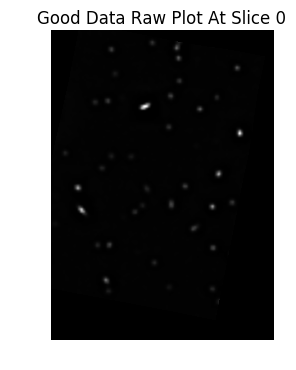

In [5]:
goodData = procData[12][1]
plt.imshow(goodData[0], cmap='gray')
plt.title('Good Data Raw Plot At Slice 0')
plt.axis('off')
plt.show()

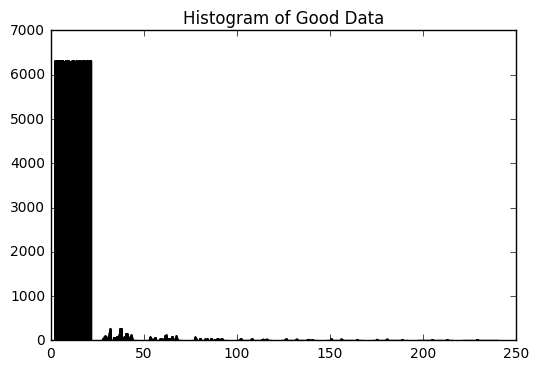

In [11]:
plt.hist(goodData[0])
plt.title("Histogram of Good Data")
plt.show()

## Prediction on Good Data 
I predict that otsuVox will clearly separate the two normal curves, extracting only the foreground

### Challenging Data

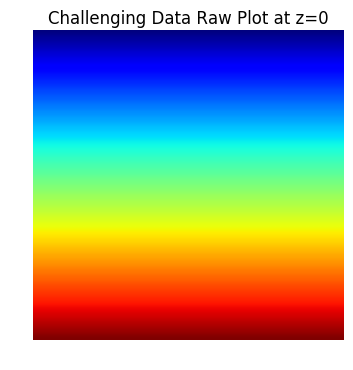

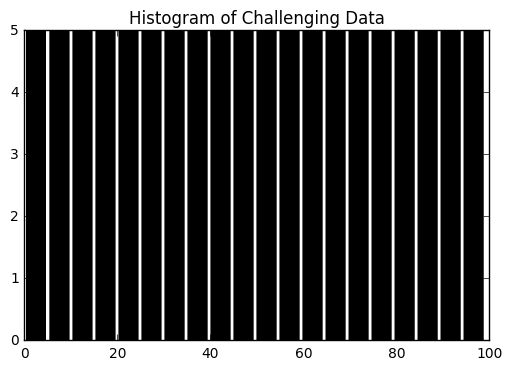

In [7]:
simDiff = np.zeros((100, 100, 100))

for i in range(100):
    for j in range(100):
        for k in range(100):
            simDiff[i][j][k] = j
            
            
plt.imshow(simDiff[5])
plt.axis('off')
plt.title('Challenging Data Raw Plot at z=0')
plt.show()
plt.hist(simDiff[0], bins=20)
plt.title("Histogram of Challenging Data")
plt.show()

## Prediction on Challenging Data 
I predict that otsuVox will will not be able to separate normal curves from the image.

# Simulation
## Generate Toy Simulation Data
### Easy Data
I believe this data will look like a grid of squares, with the squares being much brighter than the background.

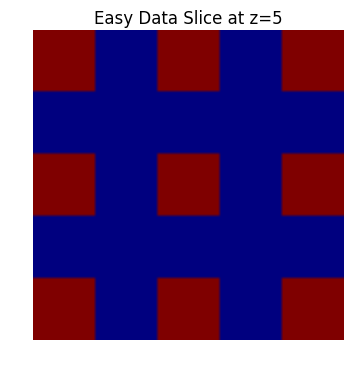

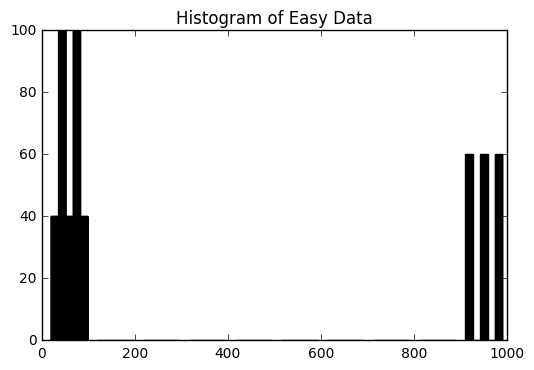

In [32]:
simEasyGrid = np.zeros((100, 100, 100))

for i in range(100):
    for j in range(100):
        for k in range(100):
            simEasyGrid[i][j][k] = 10
            
for i in range(4):
    for j in range(4):
        for k in range(4):
            simEasyGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1000
            
plt.imshow(simEasyGrid[5])
plt.axis('off')
plt.title('Easy Data Slice at z=5')
plt.show()
plt.hist(simEasyGrid[5])
plt.title('Histogram of Easy Data')
plt.show()

The easy data looks exactly as I expected. The histogram is clearly bimodal, which is the kind of data otsuVox performs well on.

## Difficult Data 
I expect that the difficult data will look like a grid, but with a gradient background.

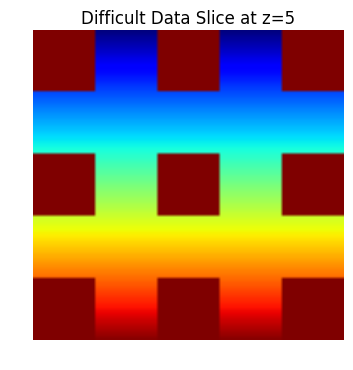

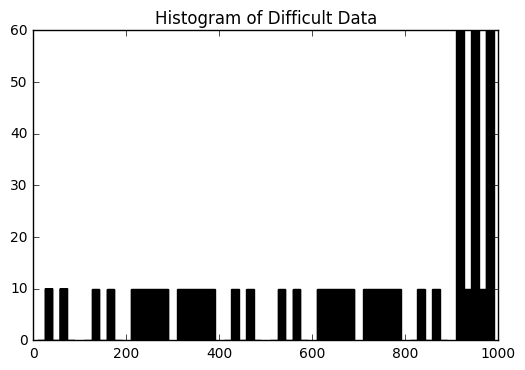

In [23]:
simDiffGrid = np.zeros((100, 100, 100))

for i in range(100):
    for j in range(100):
        for k in range(100):
            simDiffGrid[i][j][k] = 10 * j
            
for i in range(4):
    for j in range(4):
        for k in range(4):
            simDiffGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1000
            
plt.imshow(simDiffGrid[5])
plt.axis('off')
plt.title('Difficult Data Slice at z=5')
plt.show()
plt.hist(simDiffGrid[5])
plt.title('Histogram of Difficult Data')
plt.show()

The difficult data looks exactly as I expected. The histogram is clearly not bimodal, which is the kind of data otsuVox performs poorly on.

## Toy Data Analysis

For the good data, I predict that otsuVox will select the voxels in the rightmost normal curve.
For the bad data, I predict that otsuVox will randomly select one normal curve. 

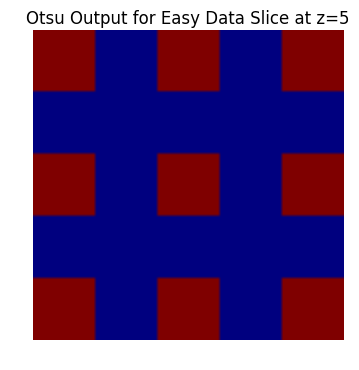

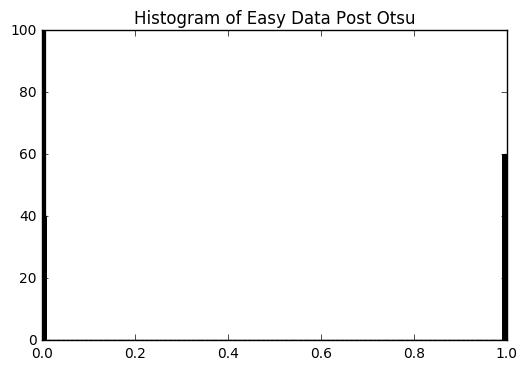

In [43]:
otsuOutEasy = otsuVox(simEasyGrid)
plt.imshow(otsuOutEasy[5])
plt.axis('off')
plt.title('Otsu Output for Easy Data Slice at z=5')
plt.show()
plt.hist(otsuOutEasy[5], bins = 100)
plt.title('Histogram of Easy Data Post Otsu')
plt.show()

As expected, otsuVox separated the background of the image from the foreground.

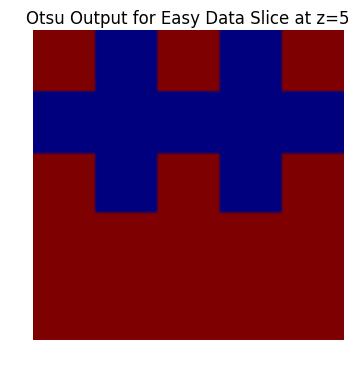

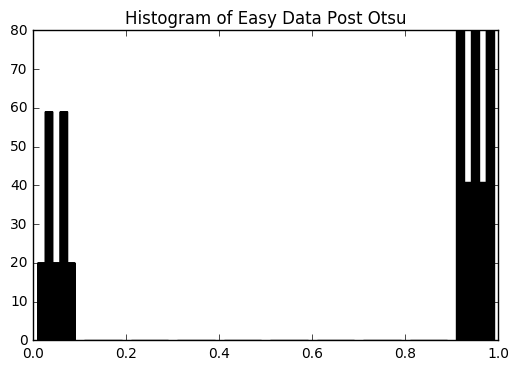

In [45]:
otsuOutEasy = otsuVox(simDiffGrid)
plt.imshow(otsuOutEasy[5])
plt.axis('off')
plt.title('Otsu Output for Easy Data Slice at z=5')
plt.show()
plt.hist(otsuOutEasy[5])
plt.title('Histogram of Easy Data Post Otsu')
plt.show()

As expected, otsuVox failed to separate the background from the foreground.

# Real Data

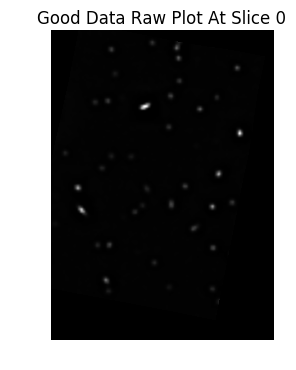

In [6]:
realData = procData[12][1]
plt.imshow(goodData[0], cmap='gray')
plt.title('Good Data Raw Plot At Slice 0')
plt.axis('off')
plt.show()

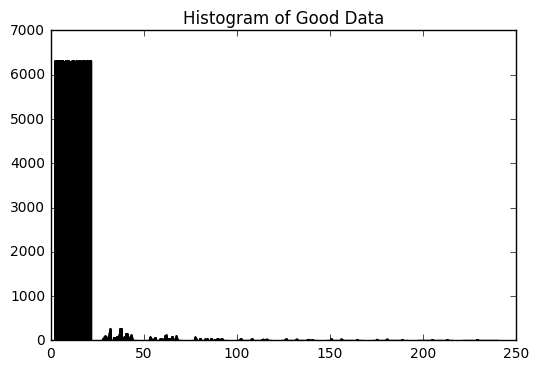

In [11]:
plt.hist(goodData[0])
plt.title("Histogram of Good Data")
plt.show()

As we can see, the real data is clearly bimodal. This means that otsuVox should be able to extract the foreground.

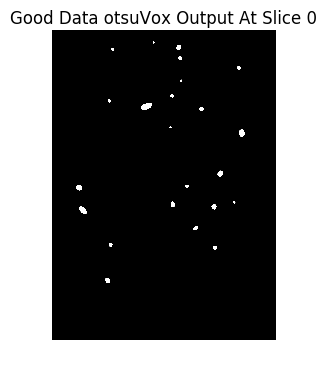

In [7]:
otsuOutReal = otsuVox(realData)
plt.imshow(otsuOutReal[0], cmap='gray')
plt.title('Good Data otsuVox Output At Slice 0')
plt.axis('off')
plt.show()

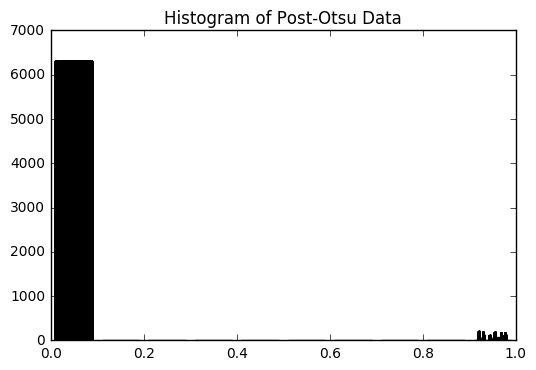

In [16]:
plt.hist(otsuOutReal[0])
plt.title("Histogram of Post-Otsu Data")
plt.show()

## Precision/Recall/F1 before otsuVox 

In [8]:
labelClusters = cLib.clusterThresh(procData[0][1], 0, 10000000)

In [17]:
rawClusters = cLib.clusterThresh(procData[12][1], 0, 10000000)

In [18]:
precision, recall, F1 = qLib.precision_recall_f1(labelClusters, rawClusters)

In [19]:
print 'Precision: ' + str(precision)
print 'Recall: ' + str(recall)
print 'F1: ' + str(F1)

Precision: 0.0
Recall: 0.0
F1: 0


## Precision/Recall/F1 before otsuVox 

In [9]:
otsuClusters = cLib.clusterThresh(otsuOutReal, 0, 10000000)

In [14]:
precision, recall, F1 = qLib.precision_recall_f1(labelClusters, otsuClusters)

In [15]:
print 'Precision: ' + str(precision)
print 'Recall: ' + str(recall)
print 'F1: ' + str(F1)

Precision: 0.61875
Recall: 0.697478991597
F1: 0.655759945732
